In [21]:
from types import SimpleNamespace
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq
from scipy.signal import windows
from scipy.fft import fftshift

from nodes.radar import Radar

In [2]:
args = SimpleNamespace(**{
  'cfg': 'configs/1443_mmwavestudio_config_continuous.lua',
  'host_ip': '192.168.33.30',
  'host_data_port': 4098,
})
radar = Radar(args)

c = 3e8                                                 # speed of light - m/s
SAMPLES_PER_CHIRP = radar.params['n_samples']           # adc number of samples per chirp
SAMPLE_RATE = radar.params['sample_rate']               # digout sample rate in Hz
FREQ_SLOPE = radar.params['chirp_slope']                # frequency slope in Hz (/s)

[INFO] Starting radar node with config: configs/1443_mmwavestudio_config_continuous.lua
[INFO] Connecting radar with host 192.168.33.30:4098
[INFO] Radar connected. Params:
platform                 : xWR14xx
adc_output_fmt           : 1
n_chirps                 : 8
rx                       : 1, 1, 1, 1
n_rx                     : 4
tx                       : 1, 1, 1
n_tx                     : 3
n_samples                : 512
frame_size               : 65536 bytes
frame_time               : 100 ms
chirp_time               : 162 µs
chirp_slope              : 60012000000000.0000 Hz/s
sample_rate              : 10000000.0000 samples/s
chirp_sampling_rate      : 80.0000 Hz
velocity_max             : 6.0125 m/s
velocity_res             : 0.7516 m/s
range_max                : 24.9950 m
range_res                : 0.0488 m
t_sweep                  : 0.0001 s


In [3]:
frame = radar.read()
frame.shape # shape (num_chirps, num_samples, num_rx)

Packet drop


(8, 512, 4)

c:\Users\signalkinetics\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Users\signalkinetics\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Users\signalkinetics\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Users\signalkinetics\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


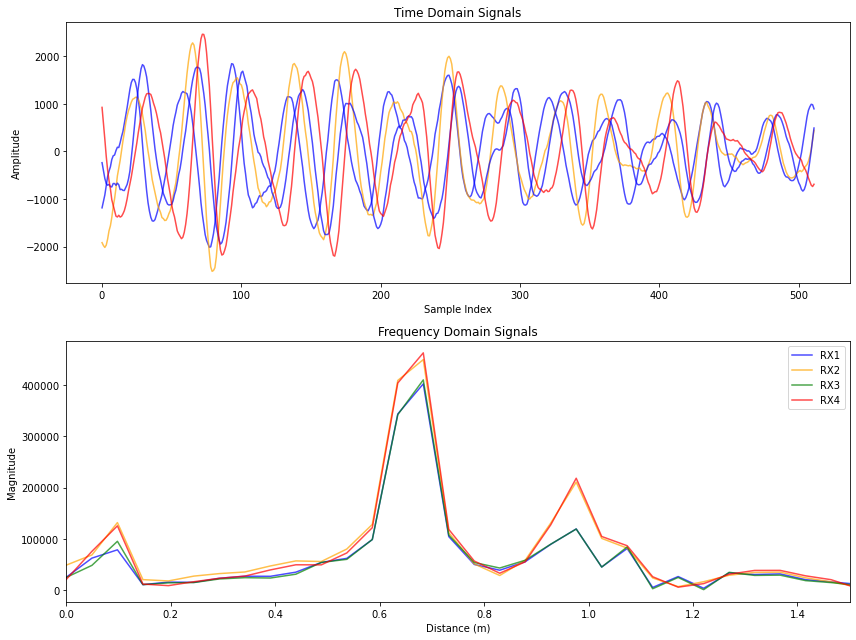

In [4]:
# signal = frame[0, :, :] # take the first chirp and first rx channel
signal = np.mean(frame, axis=0)
fft_result = fft(signal, axis=0)
fft_freqs = fftfreq(SAMPLES_PER_CHIRP, 1/SAMPLE_RATE)
fft_meters = fft_freqs * c / (2 * FREQ_SLOPE)

plt.figure(figsize=(12, 9))
# --- Time Domain Plot ---
plt.subplot(2, 1, 1)
plt.plot(signal[:, 0], color='blue', label='RX1', alpha=0.7)
plt.plot(signal[:, 1], color='orange', label='RX2', alpha=0.7)
plt.plot(signal[:, 2], color='blue', label='RX3', alpha=0.7)
plt.plot(signal[:, 3], color='red', label='RX4', alpha=0.7)
plt.title('Time Domain Signals')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

# --- Frequency Domain Plot ---
plt.subplot(2, 1, 2)
plt.plot(fft_meters[:SAMPLES_PER_CHIRP // 2],  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 0]), color='blue', label='RX1', alpha=0.7)
plt.plot(fft_meters[:SAMPLES_PER_CHIRP // 2],  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 1]), color='orange', label='RX2', alpha=0.7)
plt.plot(fft_meters[:SAMPLES_PER_CHIRP // 2],  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 2]), color='green', label='RX3', alpha=0.7)
plt.plot(fft_meters[:SAMPLES_PER_CHIRP // 2],  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 3]), color='red', label='RX4', alpha=0.7)
plt.title('Frequency Domain Signals')
plt.xlabel('Distance (m)')
plt.ylabel('Magnitude')
plt.legend()
plt.xlim(0,1.5)
plt.tight_layout()

In [ ]:
radar.close()

## Object detection

In [5]:
# avg over chirps
avg_chirps = np.mean(frame, axis=0)     # shape: (num_samples, num_rx)
# choose rx0
signal = avg_chirps[:, 0]               # shape: (num_samples,)
signal.shape

(512,)

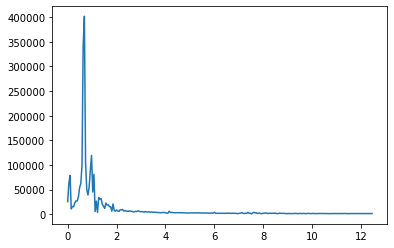

In [6]:
# ==== process data from radar with fft
fft_result = fft(signal)
fft_magnitude = np.abs(fft_result[:SAMPLES_PER_CHIRP // 2])
fft_freqs = fftfreq(SAMPLES_PER_CHIRP, 1/SAMPLE_RATE)
fft_meters = fft_freqs[:SAMPLES_PER_CHIRP // 2] * c / (2 * FREQ_SLOPE)

plt.plot(fft_meters, fft_magnitude)

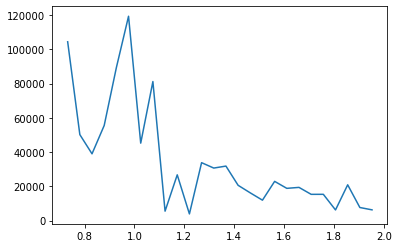

In [7]:
# ==== find peaks with distances
LOW = 0.7
HIGH = 1
range_mask = (fft_meters >= LOW) & (fft_meters <= HIGH)
fft_magnitude = fft_magnitude[range_mask]
fft_meters = fft_meters[range_mask]

plt.plot(fft_meters, fft_magnitude)

In [8]:
# ==== check if there is a strong peak at an inside box distance
THRESHOLD = 6000
any(fft_magnitude > THRESHOLD)

True

## Tests

In [66]:
df = pd.DataFrame(columns=['frame', 'low', 'high', 'state', 'experiment', 'setup', 'trial'])
df.head()

,frame,low,high,state,experiment,setup,trial


[INFO] Starting radar node with config: configs/1443_mmwavestudio_config_continuous.lua
[INFO] Connecting radar with host 192.168.33.30:4098
[INFO] Radar connected. Params:
platform                 : xWR14xx
adc_output_fmt           : 1
n_chirps                 : 8
rx                       : 1, 1, 1, 1
n_rx                     : 4
tx                       : 1, 1, 1
n_tx                     : 3
n_samples                : 512
frame_size               : 65536 bytes
frame_time               : 100 ms
chirp_time               : 162 µs
chirp_slope              : 60012000000000.0000 Hz/s
sample_rate              : 10000000.0000 samples/s
chirp_sampling_rate      : 80.0000 Hz
velocity_max             : 6.0125 m/s
velocity_res             : 0.7516 m/s
range_max                : 24.9950 m
range_res                : 0.0488 m
t_sweep                  : 0.0001 s
Packet drop
signal (512, 4)
fft res (512, 4)
fft mag (256,)
Detected: True
Max within range: 132459.08113952083


,frame,low,high,state,experiment,setup,trial
16,"[[[(-1616-1256j), (-1680-1975j), (385+224j), (...",0.52,1.2,EMPTY,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
17,"[[[(198+333j), (446+402j), (1408+1170j), (1051...",0.52,1.2,EMPTY,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
18,"[[[(-66+281j), (-489-41j), (-934-1544j), (-967...",0.52,1.2,EMPTY,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
19,"[[[(35+285j), (248+1376j), (2228+1052j), (1439...",0.52,1.2,EMPTY,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
20,"[[[(480+599j), (256+537j), (-71-1133j), (-642-...",0.52,1.2,EMPTY,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001


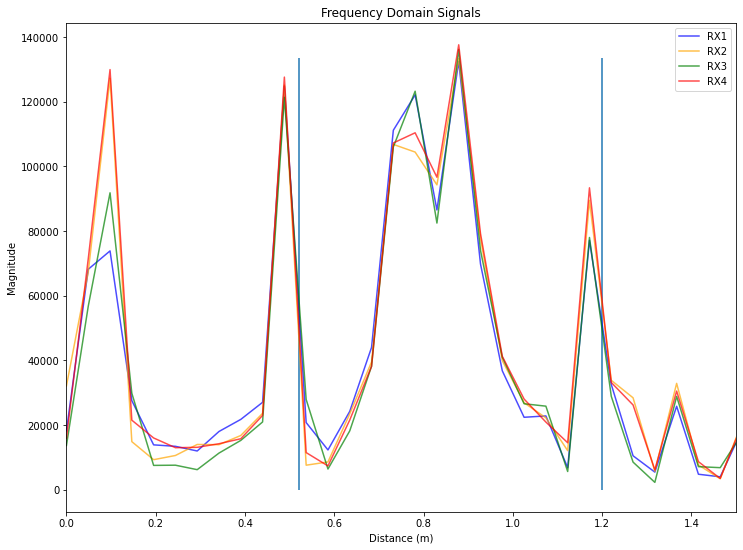

In [ ]:
EXPERIMENT = 'FINDING THRESHOLD'
SETUP = 'BOX ON BOX ON THE FLOOR'
TRIAL = '0001'
# STATE = 'EMPTY'
STATE = 'FULL'
LOW = 0.52
HIGH = 1.2

args = SimpleNamespace(**{
  'cfg': 'configs/1443_mmwavestudio_config_continuous.lua',
  'host_ip': '192.168.33.30',
  'host_data_port': 4098,
})
radar = Radar(args)

c = 3e8                                                 # speed of light - m/s
SAMPLES_PER_CHIRP = radar.params['n_samples']           # adc number of samples per chirp
SAMPLE_RATE = radar.params['sample_rate']               # digout sample rate in Hz
FREQ_SLOPE = radar.params['chirp_slope']                # frequency slope in Hz (/s)

# ==== collect data from radar
frame = radar.read()
radar.close()
# avg over chirps
avg_chirps = np.mean(frame, axis=0)     # shape: (num_samples, num_rx)
# choose rx0
signal = avg_chirps                     # shape: (num_samples, num_rx)
print('signal', signal.shape)


# ==== process data from radar with fft
fft_result = fft(signal, axis=0)
print('fft res', fft_result.shape)

rx = 0
fft_magnitude = np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, rx])
print('fft mag', fft_magnitude.shape)
fft_freqs = fftfreq(SAMPLES_PER_CHIRP, 1/SAMPLE_RATE)
fft_meters = fft_freqs[:SAMPLES_PER_CHIRP // 2] * c / (2 * FREQ_SLOPE)

# ==== find peaks with distances
range_mask = (fft_meters >= LOW) & (fft_meters <= HIGH)
fft_magnitude_masked = fft_magnitude[range_mask]
fft_meters_masked = fft_meters[range_mask]


# ==== check if there is a strong peak at an inside box distance
THRESHOLD = 3000
detection = (fft_magnitude_masked > THRESHOLD).any()
masked_max = np.max(fft_magnitude_masked)
print('Detected:', detection)
print('Max within range:', masked_max)

# plot
plt.figure(figsize=(12, 9))
plt.plot(fft_meters,  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 0]), color='blue', label='RX1', alpha=0.7)
plt.plot(fft_meters,  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 1]), color='orange', label='RX2', alpha=0.7)
plt.plot(fft_meters,  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 2]), color='green', label='RX3', alpha=0.7)
plt.plot(fft_meters,  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 3]), color='red', label='RX4', alpha=0.7)
plt.vlines([LOW, HIGH], [0, 0], [masked_max + 1000, masked_max + 1000])
plt.title('Frequency Domain Signals')
plt.xlabel('Distance (m)')
plt.ylabel('Magnitude')
plt.legend()
plt.xlim(0,1.5)


# df.loc[-1] = [frame, LOW, HIGH, STATE, EXPERIMENT, SETUP, TRIAL]
# df.index = df.index + 1  # shifting index
# df = df.sort_index()  # sorting by index
# df.tail()

In [45]:
df.loc[-1] = [frame, LOW, HIGH, STATE, EXPERIMENT, SETUP, TRIAL]
df.index = df.index + 1  # shifting index
df = df.sort_index()  # sorting by index
df.tail()

,frame,radar-to-boxtop,radar-to-boxbtm,state,experiment,setup,trial
0,"[[[(-107+190j), (181+176j), (735+597j), (768+6...",0.65,1,FULL,FINDING THRESHOLD,BOX ON THE FLOOR,0001


In [88]:
df.head()

,frame,low,high,state,experiment,setup,trial
0,"[[[(-297+189j), (-253+631j), (2064+788j), (145...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
1,"[[[(-484-278j), (-224+16j), (1589+1672j), (157...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
2,"[[[(-451-67j), (-523+206j), (1686+1718j), (181...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
3,"[[[(-780-616j), (-1088-1234j), (-714-51j), (-2...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
4,"[[[(1029+217j), (710+533j), (531+228j), (-267-...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001


In [91]:
df_processed = df.copy()
df_processed

,frame,low,high,state,experiment,setup,trial
0,"[[[(-297+189j), (-253+631j), (2064+788j), (145...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
1,"[[[(-484-278j), (-224+16j), (1589+1672j), (157...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
2,"[[[(-451-67j), (-523+206j), (1686+1718j), (181...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
3,"[[[(-780-616j), (-1088-1234j), (-714-51j), (-2...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
4,"[[[(1029+217j), (710+533j), (531+228j), (-267-...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
5,"[[[(785+762j), (622+1040j), (1257+980j), (738+...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
6,"[[[(373+380j), (-29+696j), (633+640j), (418+12...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
7,"[[[(-717-455j), (-968-1681j), (-292-354j), (-2...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
8,"[[[(300+281j), (373+652j), (1450+1404j), (994+...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001
9,"[[[(699+880j), (177+999j), (199+280j), (329+55...",0.52,1.2,FULL,FINDING THRESHOLD,BOX ON BOX ON THE FLOOR,0001


In [ ]:
# avg over chirps
avg_chirps = np.mean(frame, axis=0)     # shape: (num_samples, num_rx)
# choose rx0
signal = avg_chirps                     # shape: (num_samples, num_rx)
print('signal', signal.shape)


# ==== process data from radar with fft
fft_result = fft(signal, axis=0)
print('fft res', fft_result.shape)

rx = 0
fft_magnitude = np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, rx])
print('fft mag', fft_magnitude.shape)
fft_freqs = fftfreq(SAMPLES_PER_CHIRP, 1/SAMPLE_RATE)
fft_meters = fft_freqs[:SAMPLES_PER_CHIRP // 2] * c / (2 * FREQ_SLOPE)

# ==== find peaks with distances
range_mask = (fft_meters >= LOW) & (fft_meters <= HIGH)
fft_magnitude_masked = fft_magnitude[range_mask]
fft_meters_masked = fft_meters[range_mask]


# ==== check if there is a strong peak at an inside box distance
THRESHOLD = 3000
detection = (fft_magnitude_masked > THRESHOLD).any()
masked_max = np.max(fft_magnitude_masked)
print('Detected:', detection)
print('Max within range:', masked_max)

# plot
plt.figure(figsize=(12, 9))
plt.plot(fft_meters,  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 0]), color='blue', label='RX1', alpha=0.7)
plt.plot(fft_meters,  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 1]), color='orange', label='RX2', alpha=0.7)
plt.plot(fft_meters,  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 2]), color='green', label='RX3', alpha=0.7)
plt.plot(fft_meters,  np.abs(fft_result[:SAMPLES_PER_CHIRP // 2, 3]), color='red', label='RX4', alpha=0.7)
plt.vlines([LOW, HIGH], [0, 0], [masked_max + 1000, masked_max + 1000])
plt.title('Frequency Domain Signals')
plt.xlabel('Distance (m)')
plt.ylabel('Magnitude')
plt.legend()
plt.xlim(0,1.5)